In [1]:
# Data Analysis on virtual learning environment data from Open University based in the UK
# Data is from 4 consecutive semesters (2013 - 2014) and contains multiple data sets on student demographics, virtual learning environment info, assessment info, and student interactions with VLE resources and assessments scores

# Purpose: To determine the factors that contribtue to student's passing courses vs. failing/withdrawing from courses

# Data set retrieved from: https://www.kaggle.com/anlgrbz/student-demographics-online-education-dataoulad

In [2]:
# import relevant libraries
library(tidyverse)
library(rpart)
library(rpart.plot)
library(gmodels)
library(randomForest)
library(ipred)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin



In [3]:
# load all datasets
assessments <- read.csv("assessments.csv")
studAssessments <- read.csv("studentAssessment.csv")
courses <- read.csv("courses.csv")
studInfo <- read.csv("studentInfo.csv")
studReg <- read.csv("studentRegistration.csv")
studVle <- read.csv("studentVle.csv")
vle <- read.csv("vle.csv")

In [4]:
#multiple datasets have 'code_module' so create quick function that we can apply as we work through dif datasets
RenameCourse <- function (dataSet) {
  recode(dataSet$code_module, AAA = "Mod1", BBB = "Mod2",
         CCC = "Mod3", DDD = "Mod4", EEE = "Mod5", FFF = "Mod6", GGG = "Mod7")
} 

In [5]:
######### look at distribution of final result (4 categories) based on the course

# combine needed datasets together
FinalByMod <- studInfo %>%
  left_join(courses)

FinalByMod$code_module  <- RenameCourse(FinalByMod)

#head(FinalByMod) # double check output

Joining, by = c("code_module", "code_presentation")


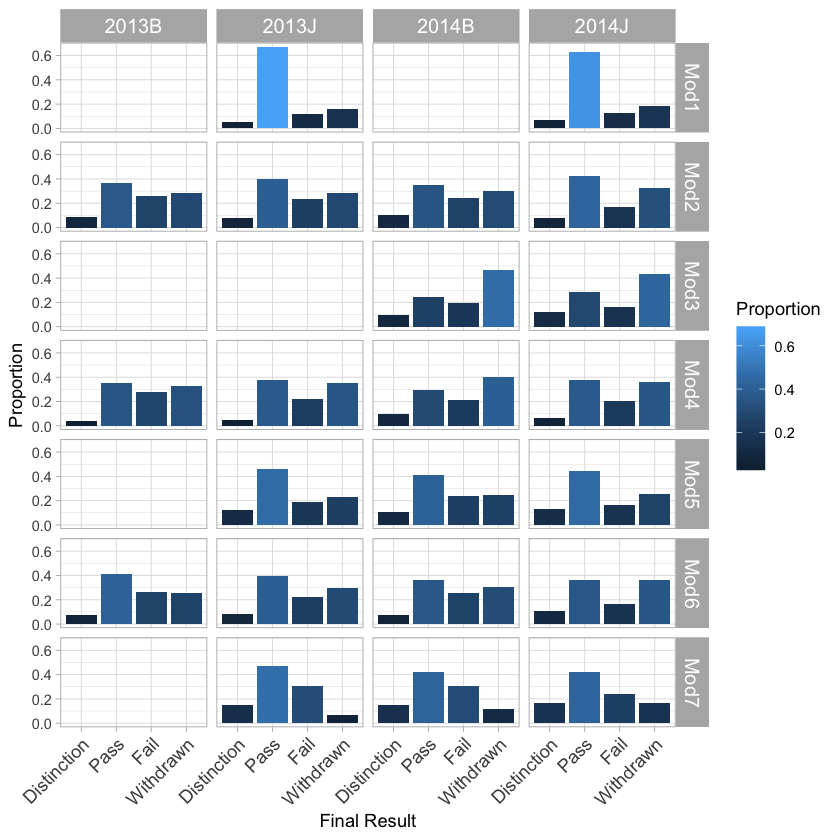

In [7]:
# Plot distribution of final result - Separate by Course & Semester

# Set order of final result levels we want to display:
resultOrder  <- c("Distinction","Pass","Fail","Withdrawn")
FinalByMod$final_result  <- factor(FinalByMod$final_result, levels = resultOrder)

ggplot(FinalByMod, aes(x=final_result) ) +
  geom_bar(aes( y = ..prop.., 
                group = 1, 
                fill = ..prop..))+
  facet_grid(code_module ~ code_presentation) +
  labs(x = "Final Result", y = "Proportion", fill = "Proportion") +
  #scale_x_discrete(labels = c("Distin","F","P","W")) +
theme_light() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1,
                                  size = 11),
         strip.text = element_text(size = 12))

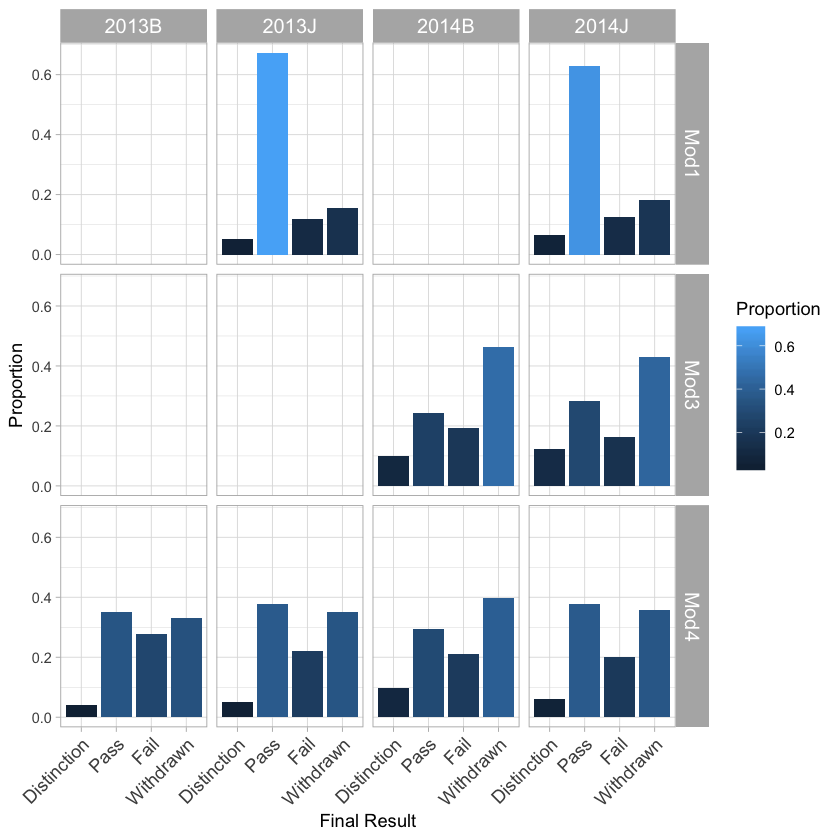

In [8]:
#### Select only a few courses and display using Opt2 method 
FinalByMod %>%
  filter(code_module %in% c("Mod1", "Mod3","Mod4") ) %>%
  ggplot(aes(final_result)) +
  geom_bar(aes( y = ..prop.., 
                group = 1, 
                fill = ..prop..))+
  facet_grid(code_module ~ code_presentation) +
  labs(x = "Final Result", y = "Proportion",fill = "Proportion") +
  #scale_x_discrete(labels = c("Distin","F","P","W")) +
theme_light() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1,
                                  size = 11),
         strip.text = element_text(size = 12))

In [9]:
# Check if different lenghts of courses
#summary(courses)
summary(courses)[,3]

"Min.   :234.0  " "1st Qu.:241.0  " "Median :261.5  " "Mean   :255.5  " 
                                                      
"3rd Qu.:268.0  " "Max.   :269.0  "                NA

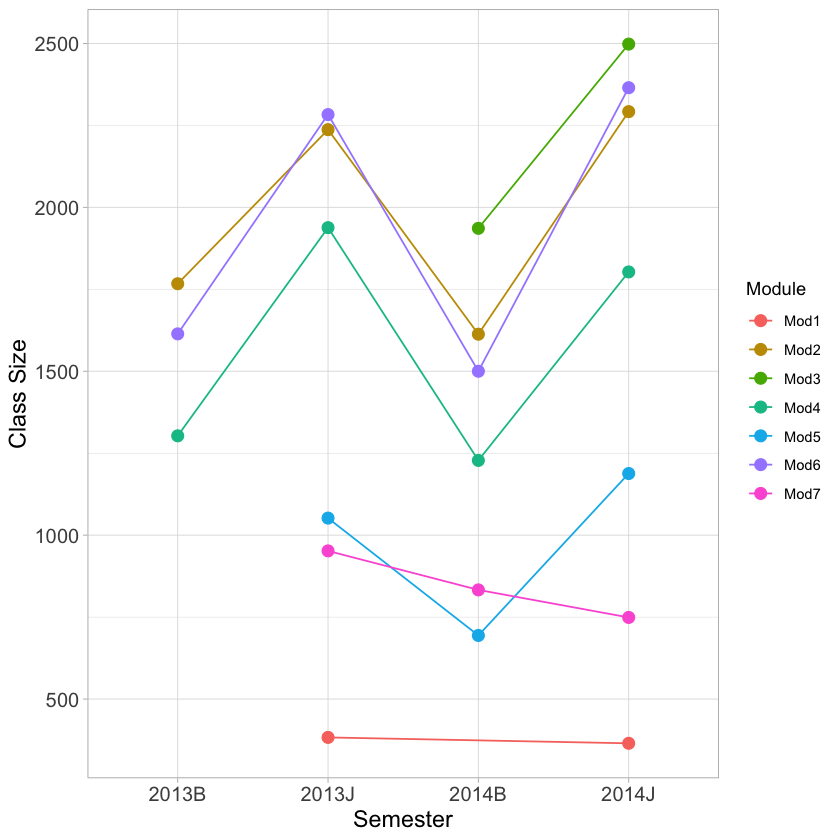

In [10]:
# Plot # of students enrolled in each course over 4 semesters
FinalByMod %>%
  group_by(code_module, code_presentation) %>%
  summarise(ClassSize = n()) %>%
  ggplot( aes (code_presentation, ClassSize)) +
  geom_point( stat = "identity",
              aes(color = code_module) ,
              size = 3) +
  geom_line ( aes( group = code_module, 
                   color = code_module) )+
theme_light() +
labs(y = "Class Size", x = "Semester", color = "Module") +
theme(axis.text = element_text(size = 12),
     axis.title = element_text(size = 14))

Joining, by = c("code_module", "code_presentation", "id_site")
Joining, by = c("code_module", "code_presentation", "id_student")


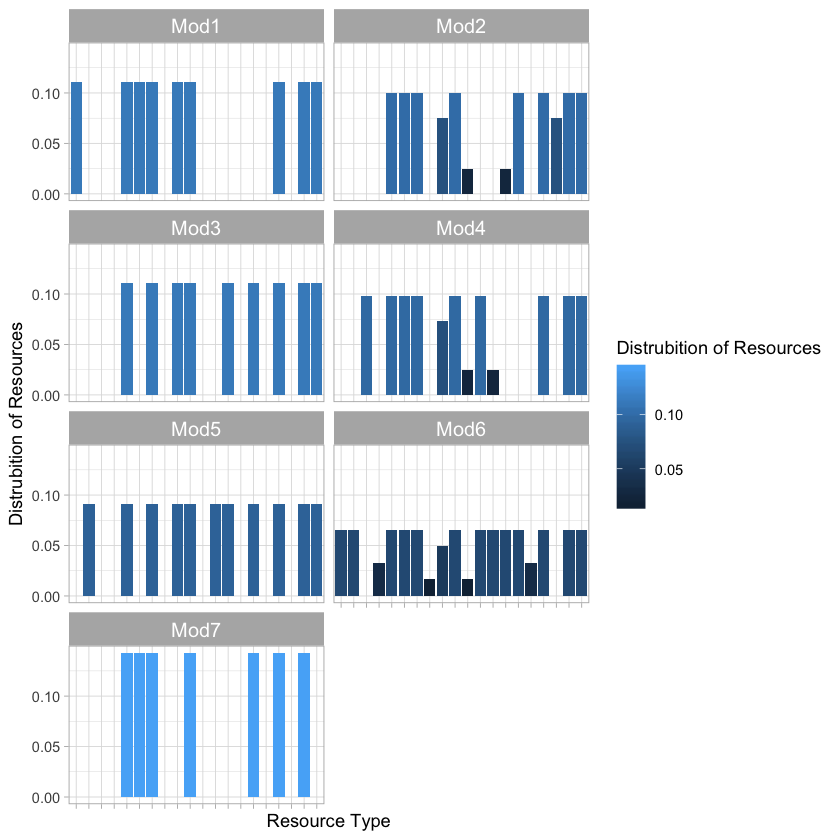

In [56]:
# Next let's try to get a feeling for what may differ between the course modules in terms of the VLE
VleByMod <- 
  left_join(studVle, vle) %>%
  left_join(studInfo)

VleByMod$code_module  <- RenameCourse(VleByMod)

VleByMod %>%
  group_by(code_module, code_presentation, activity_type) %>%
  summarise(TotVLEtypes = n()) %>%
  ggplot(aes(activity_type)) +
  geom_bar(aes(y = ..prop.., 
               fill = ..prop..,
              group = 1) ) +
  facet_wrap(~code_module, nrow = 4)+
theme_light() +
theme(axis.text.x = element_blank()) +
labs(y = "Distrubition of Resources", x = "Resource Type", fill = "Distrubition of Resources") +
theme(strip.text = element_text(size = 12))

In [12]:
##### Create dataset with desired variables to classify what leads to large % of passing vs failing vs. withdraws
CourseInfoVLE <- vle %>%
  group_by(code_module, activity_type) %>%
  summarise(TotVLEs = n()) %>% # count # of VLEs per activity type
  spread(activity_type, TotVLEs) # make column for each act.type

CourseInfoVLE$NoVLETypes <- apply(CourseInfoVLE[,-1], 1, 
                                function(x) sum(!is.na(x)) )

In [13]:
CourseInfoAssess <- assessments %>%
  filter(!is.na(date)) %>% # set to NA if no Exam given
  group_by(code_module, assessment_type) %>%
  summarise(TotAssess = n()) %>%
  spread(assessment_type, TotAssess) 

CourseInfoAssess$NoAssessTypes <- apply(CourseInfoAssess[,2:4], 1, 
                                         function(x) sum(!is.na(x)))

In [14]:
# Create CourseInfo variable that has both VLE and Assessment info
CourseInfo <- left_join(CourseInfoVLE, CourseInfoAssess)

# add Class Size variable:
ClassSize <- courses %>%
  group_by(code_module) %>%
  summarise(AvgClassSize = mean(module_presentation_length))

CourseInfo <- left_join(CourseInfo, ClassSize)

Joining, by = "code_module"
Joining, by = "code_module"


In [15]:
########## Look at date of submission for each assessment

studAssessments1 <- studAssessments %>%
  left_join(assessments) %>% # need to get info about course module
  group_by(code_module,id_assessment) %>%
  mutate(date_submitted = date_submitted - date) %>%
  ungroup() %>%
  group_by(code_module,id_student) %>%
  summarise(DateSubAvg = mean(date_submitted))

head(studAssessments1)

Joining, by = "id_assessment"


code_module,id_student,DateSubAvg
AAA,6516,-2.6
AAA,11391,-1.8
AAA,24734,7.4
AAA,26192,-1.2
AAA,28061,1.0
AAA,28400,0.0


In [16]:
Score_AssessType <- 
  left_join(studAssessments, assessments) %>%
  dplyr::select(-date, -is_banked) %>%
  left_join(studVle) %>% # add vle info based on student id
  left_join(vle) # get info about the vle 
 # filter(assessment_type != "Exam")

# get avg clicks for each student per course
VLEuseByStud <- Score_AssessType %>% 
  group_by(code_module, id_student) %>%
  mutate(AvgClicks = mean(sum_click, na.rm = T)) %>%
  distinct(id_student, code_module, AvgClicks)

# get avg score for each assessment type for each student per course
AssessScoreByStud <- Score_AssessType %>%
  group_by(code_module, id_student, assessment_type) %>%
  mutate(AvgScore = mean(score, na.rm = T)) %>%
  distinct(id_student, assessment_type, AvgScore) %>%
  spread(key = assessment_type, value = AvgScore)

Joining, by = "id_assessment"
Joining, by = c("id_student", "code_module", "code_presentation")
Joining, by = c("code_module", "code_presentation", "id_site")


In [17]:
# create combined dataframe:
CombData <- left_join(VLEuseByStud, AssessScoreByStud) %>%
  left_join(studInfo[,c("id_student",
                                            "final_result",
                                            "code_module")]) %>%
  left_join(studAssessments1) %>%
  left_join(ClassSize) %>%
  left_join(CourseInfoVLE[,c("code_module","NoVLETypes")]) %>%
  distinct(id_student, code_module, .keep_all = T)




Joining, by = c("id_student", "code_module")
Joining, by = c("id_student", "code_module")
Joining, by = c("id_student", "code_module")
Joining, by = "code_module"
Joining, by = "code_module"


In [18]:
CombData$AssessAvg = apply(subset(CombData, select = c(CMA,Exam,TMA)), 1, 
                            function(x) mean(x,na.rm = T) )

In [19]:
head(CombData)

id_student,code_module,AvgClicks,CMA,Exam,TMA,final_result,DateSubAvg,AvgClassSize,NoVLETypes,AssessAvg
11391,AAA,4.765306,NA,NA,82.0,Pass,-1.8,268.5,9,82.0
28400,AAA,3.337209,NA,NA,66.4,Pass,0.0,268.5,9,66.4
31604,AAA,3.254902,NA,NA,76.0,Pass,-2.0,268.5,9,76.0
32885,AAA,2.937500,NA,NA,54.4,Pass,11.4,268.5,9,54.4
38053,AAA,3.381743,NA,NA,68.0,Pass,2.0,268.5,9,68.0
45462,AAA,4.202817,NA,NA,68.0,Pass,0.4,268.5,9,68.0


In [20]:
CombData <- CombData %>%
  left_join(CourseInfoAssess[,c("code_module","NoAssessTypes")], 
            by = "code_module") %>%
  select( -c(Exam,CMA, TMA) )
  #dplyr::select(!c(Exam,CMA,TMA))

head(CombData)

id_student,code_module,AvgClicks,final_result,DateSubAvg,AvgClassSize,NoVLETypes,AssessAvg,NoAssessTypes
11391,AAA,4.765306,Pass,-1.8,268.5,9,82.0,1
28400,AAA,3.337209,Pass,0.0,268.5,9,66.4,1
31604,AAA,3.254902,Pass,-2.0,268.5,9,76.0,1
32885,AAA,2.937500,Pass,11.4,268.5,9,54.4,1
38053,AAA,3.381743,Pass,2.0,268.5,9,68.0,1
45462,AAA,4.202817,Pass,0.4,268.5,9,68.0,1


In [21]:
CombData <- CombData[,-c(1,2)]

head(CombData)
str(CombData)


AvgClicks,final_result,DateSubAvg,AvgClassSize,NoVLETypes,AssessAvg,NoAssessTypes
4.765306,Pass,-1.8,268.5,9,82.0,1
3.337209,Pass,0.0,268.5,9,66.4,1
3.254902,Pass,-2.0,268.5,9,76.0,1
2.937500,Pass,11.4,268.5,9,54.4,1
3.381743,Pass,2.0,268.5,9,68.0,1
4.202817,Pass,0.4,268.5,9,68.0,1


Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	25087 obs. of  7 variables:
 $ AvgClicks    : num  4.77 3.34 3.25 2.94 3.38 ...
 $ final_result : Factor w/ 4 levels "Distinction",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ DateSubAvg   : num  -1.8 0 -2 11.4 2 0.4 2.6 1.4 -4.6 -0.8 ...
 $ AvgClassSize : num  268 268 268 268 268 ...
 $ NoVLETypes   : int  9 9 9 9 9 9 9 9 9 9 ...
 $ AssessAvg    : num  82 66.4 76 54.4 68 68 72.4 71.4 78 74 ...
 $ NoAssessTypes: int  1 1 1 1 1 1 1 1 1 1 ...


In [22]:
############# Run Decision Tree Analysis
table(CombData$final_result) # look at proportions of final result labels

# make training set
totObs <- dim(CombData)[1]

set.seed(8)
train_sample <- sample(totObs, .65*totObs, replace = F) # make 90% of data training set
Data_Train <- CombData[train_sample,]
Data_Test <- CombData[-train_sample,]

# double check proportions of training/test sets
prop.table(table(Data_Train$final_result))
prop.table(table(Data_Test$final_result))



Distinction        Fail        Pass   Withdrawn 
       2983        5406       12044        4654 


Distinction        Fail        Pass   Withdrawn 
  0.1194039   0.2172207   0.4760824   0.1872930 


Distinction        Fail        Pass   Withdrawn 
  0.1179820   0.2122765   0.4875299   0.1822116 

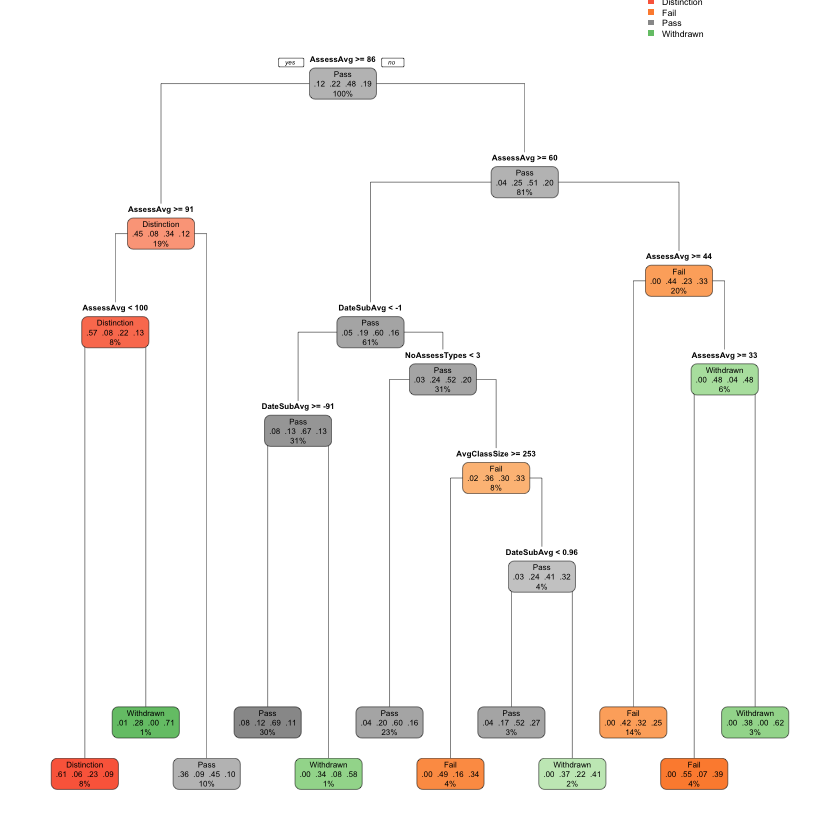

In [23]:
tree1 <- rpart(final_result~., data = Data_Train, 
               method = 'class',
               control = rpart.control(minsplit = 1,
                                     cp = .005 ) )
                                     # maxdepth = 5) )


            
rpart.plot(tree1, extra = 104, type = 1,
          branch = 1)

In [24]:
# Calculate accuracy of tree (on its own training set)
trainPred  <- predict(tree1, Data_Train, type = "class")
sum(Data_Train$final_result == trainPred)/length(trainPred)


[1] 0.5770269

In [25]:
# Calculate accuracy of predicting test data set
testPred  <- predict(tree1, Data_Test, type = "class")
sum(Data_Test$final_result == testPred)/length(testPred)

[1] 0.5811411

In [26]:
# Write function to calculate prediction accuracy on test set

PredAcc <- function(table) {
  return( sum ( diag(table) ) /sum(table))
}

In [27]:
# Applying bagging to reduce variance/overfitting of the model 

bagTest <- ipredbagg(Data_Train$final_result, Data_Train[,-2], nbagg = 200, method = 'class',
               control = rpart.control(minsplit = 1,
                                       cp = .005))
bagTest
bagPred <- predict(bagTest, Data_Test, type = "class")
tableBag <- table(Data_Test$final_result, bagPred)
PredAcc(tableBag)


Bagging classification trees with 200 bootstrap replications 


[1] 0.5883157

In [28]:
### get data ready to run random forests - remove NA values so we have complete cases
Data_TrainRF  <- na.omit(Data_Train)
Data_TestRF  <- na.omit(Data_Test)


In [29]:
tree1rf  <- randomForest(Data_TrainRF[,-2],
                         Data_TrainRF$final_result,
                         ntree = 200,
                        maxnodes = 10) 

predRF  <- predict(tree1rf, Data_TestRF, type = "class")
sum(Data_TestRF$final_result == predRF) / length(predRF)

[1] 0.5411901

In [30]:
print(tree1rf)


Call:
 randomForest(x = Data_TrainRF[, -2], y = Data_TrainRF$final_result,      ntree = 200, maxnodes = 10) 
               Type of random forest: classification
                     Number of trees: 200
No. of variables tried at each split: 2

        OOB estimate of  error rate: 46.72%
Confusion matrix:
            Distinction Fail Pass Withdrawn class.error
Distinction         104    1 1448         0  0.93303284
Fail                 14  825 2273       183  0.74962064
Pass                 62  227 6305         1  0.04397271
Withdrawn            19  569 1929       436  0.85235354


,MeanDecreaseGini
AvgClicks,66.53508
DateSubAvg,188.14968
AvgClassSize,101.84495
NoVLETypes,108.28998
AssessAvg,505.34444
NoAssessTypes,31.03288


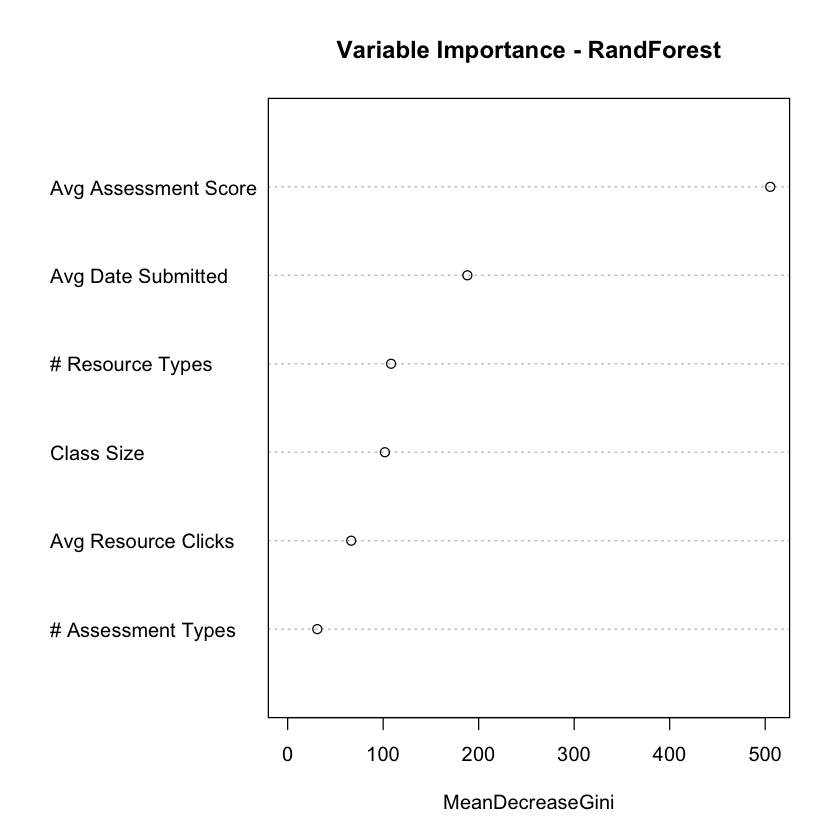

In [31]:
#Evaluate variable importance
importance(tree1rf)
varImpPlot(tree1rf, 
           labels =  c("# Assessment Types", "Avg Resource Clicks", "Class Size",
            "# Resource Types", "Avg Date Submitted",
           "Avg Assessment Score") ,
          main = "Variable Importance - RandForest")


In [35]:
getTree(tree1rf, labelVar = T)

left daughter,right daughter,split var,split point,status,prediction
2,3,AssessAvg,66.354167,1,NA
4,5,AssessAvg,40.550000,1,NA
6,7,AvgClassSize,256.000000,1,NA
8,9,DateSubAvg,1.393939,1,NA
10,11,AvgClassSize,263.916667,1,NA
12,13,AssessAvg,85.838095,1,NA
14,15,AssessAvg,84.708333,1,NA
16,17,DateSubAvg,1.162338,1,NA
18,19,AvgClicks,3.048616,1,NA
0,0,NA,0.000000,-1,Fail


In [201]:








# Repeat classification but remove AssessAvg as a factor 

In [36]:
head(CombData)
CombData_noAssess  <- select(CombData, -AssessAvg)
head(CombData_noAssess)

AvgClicks,final_result,DateSubAvg,AvgClassSize,NoVLETypes,AssessAvg,NoAssessTypes
4.765306,Pass,-1.8,268.5,9,82.0,1
3.337209,Pass,0.0,268.5,9,66.4,1
3.254902,Pass,-2.0,268.5,9,76.0,1
2.937500,Pass,11.4,268.5,9,54.4,1
3.381743,Pass,2.0,268.5,9,68.0,1
4.202817,Pass,0.4,268.5,9,68.0,1


AvgClicks,final_result,DateSubAvg,AvgClassSize,NoVLETypes,NoAssessTypes
4.765306,Pass,-1.8,268.5,9,1
3.337209,Pass,0.0,268.5,9,1
3.254902,Pass,-2.0,268.5,9,1
2.937500,Pass,11.4,268.5,9,1
3.381743,Pass,2.0,268.5,9,1
4.202817,Pass,0.4,268.5,9,1


In [37]:
# make training set
totObs <- dim(CombData_noAssess)[1]

set.seed(111)
train_sample <- sample(totObs, .65*totObs) # make 90% of data training set
Data_Train <- CombData_noAssess[train_sample,]
Data_Test <- CombData_noAssess[-train_sample,]

# double check proportions of training/test sets
prop.table(table(Data_Train$final_result))
prop.table(table(Data_Test$final_result))


Distinction        Fail        Pass   Withdrawn 
  0.1163375   0.2221268   0.4751012   0.1864344 


Distinction        Fail        Pass   Withdrawn 
  0.1236761   0.2031659   0.4893520   0.1838059 

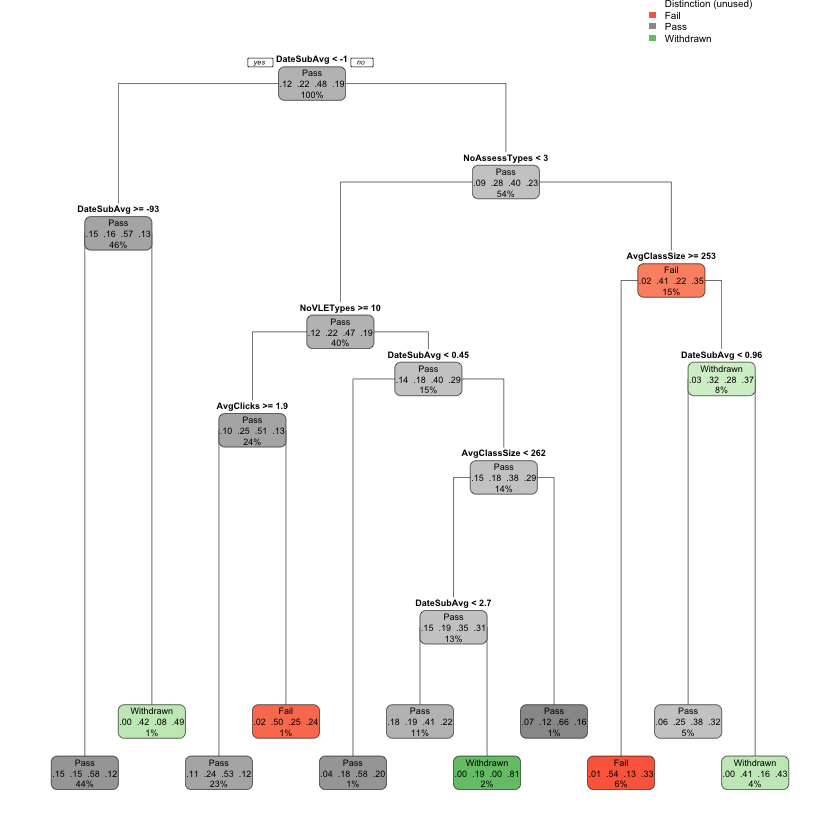

In [38]:
tree2 <- rpart(final_result~., data = Data_Train, 
               method = 'class',
              control = rpart.control(minsplit = 1,
                                     cp = .005 ) )
                #                      maxdepth = 5) )


            
rpart.plot(tree2, extra = 104, type = 1,
          branch = 1)

In [39]:
tree2pred  <- predict(tree2, Data_Test, type = "class")
tableTree2  <-  table(Data_Test$final_result, tree2pred)
PredAcc(tableTree2)

[1] 0.5431044

In [40]:
# get datasets ready for RF
Data_TrainRF2  <- na.omit(Data_Train)
Data_TestRF2  <- na.omit(Data_Test)

In [41]:
tree2rf  <- randomForest(Data_TrainRF2[,-2],
                         Data_TrainRF2$final_result,
                         ntree = 200,
                        maxnodes = 10) 

predRF  <- predict(tree2rf, Data_TestRF2, type = "class")
sum(Data_TestRF2$final_result == predRF) / length(predRF)

[1] 0.5347669

,MeanDecreaseGini
AvgClicks,91.31937
DateSubAvg,278.68544
AvgClassSize,181.59967
NoVLETypes,168.43449
NoAssessTypes,61.13597


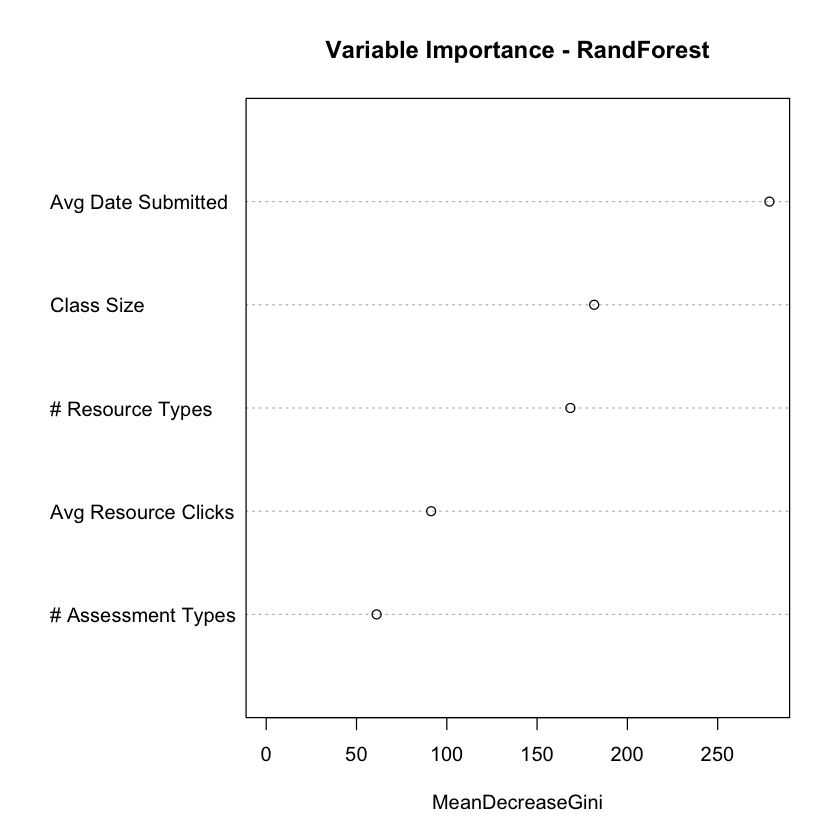

In [42]:
#Evaluate variable importance
importance(tree2rf)
varImpPlot(tree2rf, 
          labels =  c("# Assessment Types", "Avg Resource Clicks", 
                      "# Resource Types", "Class Size", 
                      "Avg Date Submitted") ,
          main = "Variable Importance - RandForest")
#, 
      #    labels = "Date")

In [54]:
getTree(tree2rf, labelVar = T) 




left daughter,right daughter,split var,split point,status,prediction
2,3,AvgClassSize,256.000000,1,NA
4,5,NoVLETypes,10.500000,1,NA
6,7,NoVLETypes,8.000000,1,NA
8,9,DateSubAvg,2.916667,1,NA
10,11,NoAssessTypes,2.500000,1,NA
0,0,NA,0.000000,-1,Pass
12,13,AvgClassSize,263.916667,1,NA
14,15,DateSubAvg,-1.250000,1,NA
16,17,AvgClicks,11.795341,1,NA
18,19,AvgClicks,1.879323,1,NA
